In [2]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import Huber
from keras.metrics import MeanSquaredError, MeanAbsoluteError,RootMeanSquaredError
from keras import Sequential, layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

2024-08-20 18:50:35.512554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 18:50:35.512694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 18:50:35.676726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Hyper parameters
PATCH_SIZE = 64
BATCH_SIZE = 200
EPOCHS = 80

In [4]:
val_files = {
    "../patches-64/skull_decimated.npy", 
    "../patches-64/ant_decimated.npy", 
    "../patches-64/vase_decimated.npy", 
    "../patches-64/isis_decimated.npy", 
    "../patches-64/teddy_decimated.npy",
    "../patches-64/teapot_decimated.npy"
}

patche_files = sorted(glob.glob('../patches-64/*.npy'))
patche_files = list(set(patche_files) - val_files)
saliency_files = [
    f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}" 
    for f in patche_files
]

print('Number of patches:', len(patche_files))
print('Number of saliency maps:', len(saliency_files))

Number of patches: 43
Number of saliency maps: 43


In [5]:
X_train = np.concatenate([np.load(f, mmap_mode="r").astype(np.uint8) for f in patche_files])
y_train = np.concatenate([np.loadtxt(f).astype(np.float32) for f in saliency_files])
    
X_train, y_train = shuffle(X_train, y_train)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

((859999, 64, 64, 3), (859999,), dtype('uint8'), dtype('float32'))

In [6]:
# Define the CNN model
model = Sequential()

# Convolutional layers with L2 regularization
model.add(layers.Conv2D(32, (3, 3), padding="same", strides=(1, 1), activation="relu", input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"))

model.add(layers.Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"))

model.add(layers.Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"))

# Flatten the output from convolutional layers
model.add(layers.Flatten())

# Dense layers with L2 regularization
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=Huber(),
              metrics=[
                  MeanSquaredError(name='mse'),
                  MeanAbsoluteError(name='mae'),
                  RootMeanSquaredError(name='rmse'),
              ])

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,256,705 (8.61 MB)

 Trainable params: 2,256,705 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
# fit the model
saliency_model = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/80
   7/3440 ━━━━━━━━━━━━━━━━━━━━ 1:09 20ms/step - loss: 0.4254 - mae: 0.9049 - mse: 0.8507 - rmse: 0.9223

I0000 00:00:1724179987.843504      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724179987.868607      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4307 - mae: 0.9117 - mse: 0.8615 - rmse: 0.9282

W0000 00:00:1724180061.143347      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724180066.534928      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 93s 24ms/step - loss: 0.4307 - mae: 0.9117 - mse: 0.8615 - rmse: 0.9282 - val_loss: 0.4308 - val_mae: 0.9121 - val_mse: 0.8617 - val_rmse: 0.9283 - learning_rate: 1.0000e-04
Epoch 2/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - loss: 0.4306 - mae: 0.9116 - mse: 0.8613 - rmse: 0.9280 - val_loss: 0.4308 - val_mae: 0.9121 - val_mse: 0.8617 - val_rmse: 0.9283 - learning_rate: 1.0000e-04
Epoch 3/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - loss: 0.4308 - mae: 0.9119 - mse: 0.8617 - rmse: 0.9283 - val_loss: 0.4308 - val_mae: 0.9121 - val_mse: 0.8617 - val_rmse: 0.9283 - learning_rate: 1.0000e-04
Epoch 4/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - loss: 0.4307 - mae: 0.9117 - mse: 0.8614 - rmse: 0.9281 - val_loss: 0.4308 - val_mae: 0.9121 - val_mse: 0.8617 - val_rmse: 0.9283 - learning_rate: 1.0000e-04
Epoch 5/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - loss: 0.4307 - mae: 0.9117 - mse: 0.8614 - rmse: 0.9281 - val_loss: 0.4308 - val_mae: 0.9

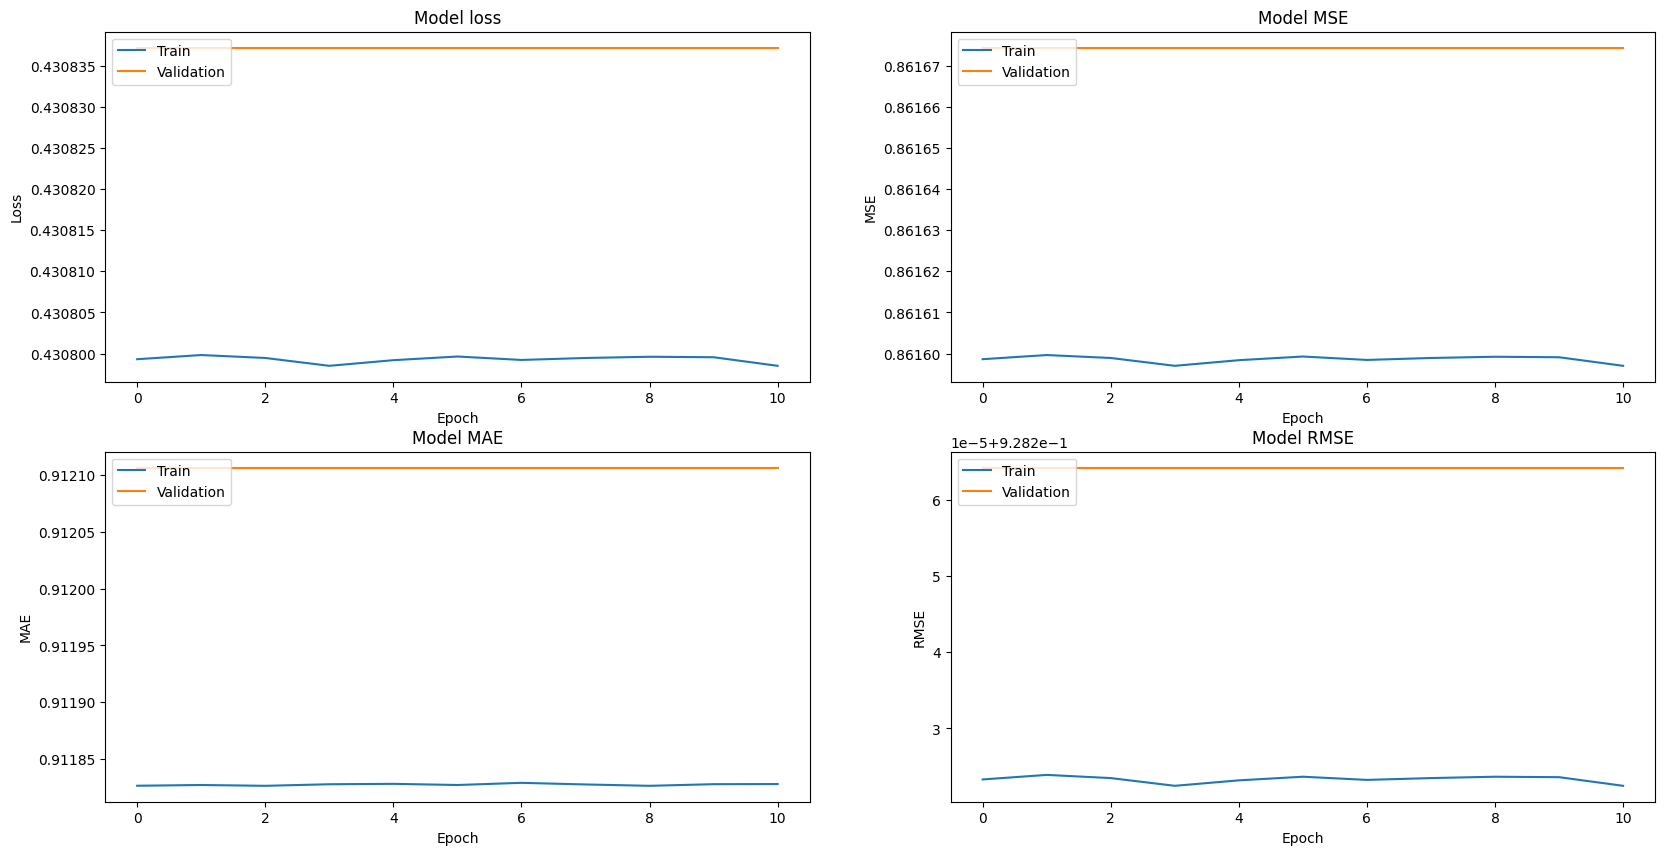

In [9]:
plt.figure(figsize=(20, 10))
# Plot the training and validation loss
plt.subplot(2, 2, 1)
plt.plot(saliency_model.history['loss'][0:])
plt.plot(saliency_model.history['val_loss'][0:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(saliency_model.history['mse'][0:])
plt.plot(saliency_model.history['val_mse'][0:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(saliency_model.history['mae'][0:])
plt.plot(saliency_model.history['val_mae'][0:])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(saliency_model.history['rmse'][0:])
plt.plot(saliency_model.history['val_rmse'][0:])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
model.save('../saved-models/original-model-64.h5')

In [11]:
import gc
del X_train 
del y_train
gc.collect()

15120

In [12]:
# evaluate model
X_test = np.concatenate([np.load(f).astype(np.uint8) for f in val_files])
y_test = np.concatenate([np.loadtxt(f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}").astype(np.float32) for f in val_files])
loss, mse, mae, rmse = model.evaluate(X_test, y_test, verbose=1)
print("Loss: ", loss)
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

  71/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.4269 - mae: 0.9114 - mse: 0.8537 - rmse: 0.9237

W0000 00:00:1724180848.517510      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.4371 - mae: 0.9246 - mse: 0.8742 - rmse: 0.9350
Loss:  0.433030903339386
MSE:  0.866061806678772
MAE:  0.9199399352073669
RMSE:  0.9306244254112244
